# Build an AutoEncoder Model With MNIST Datatset

In [1]:
# import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np


/home/moussa/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Prepare MNIST Dataset

### Load MNSIT Dataset

In [2]:
class FlattenTensor(nn.Module):
    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        return tensor.view(-1)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

In [3]:
mnist = datasets.MNIST('../files/', download=False, 
                      transform= torchvision.transforms.Compose([
                          torchvision.transforms.ToTensor(),
                          FlattenTensor()
                      ])
        )

In [4]:
mnist_base  = datasets.MNIST('../files/', download=False)

In [5]:
img, _ = mnist_base[0]

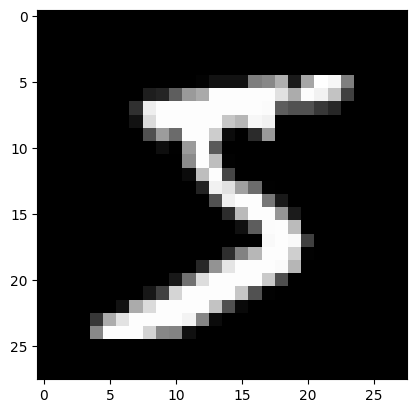

In [6]:
plt.imshow(img, cmap="gray")

### Split Dataset

In [21]:
train_data, test_data = random_split(mnist, [50000, 10000])

In [22]:
print("train data size:", len(train_data))

train data size: 50000


In [23]:
print("test data size: ", len(test_data))

test data size:  10000


### Define DataLoader

In [140]:
batch_size = 10000

In [141]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [142]:
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)

## Build The AutoEncoder Model

In [9]:
class AutoEncoder(nn.Module):

    def __init__(self, ) -> None:
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16), 
            nn.ReLU(),
            nn.Linear(16, 8)
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128), 
            nn.ReLU(),
            nn.Linear(128, 28*28) 
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = self.encoder(input)
        return self.decoder(out)

In [502]:
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
        )

    def forward(self, x):
        x = x.view(-1, 28, 28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [503]:
model = AutoencoderCNN()

In [505]:
# model.encoder(mnist[0][0].view(-1, 28, 28))

In [506]:
mnist[0][0].view(-1, 28, 28).flatten().shape

torch.Size([784])

In [507]:
res = model(mnist[0][0])

In [508]:
res.shape

torch.Size([1, 28, 28])

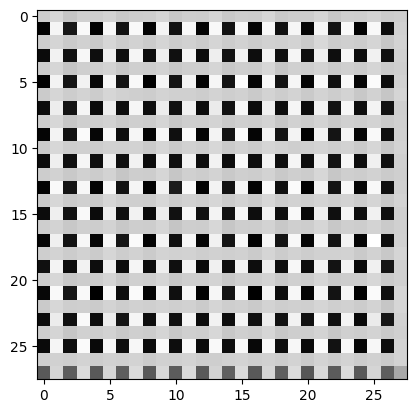

In [509]:
plt.imshow(res.detach().numpy().reshape(28, 28), cmap="gray")

In [510]:
model

AutoencoderCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [511]:
criterion = nn.MSELoss()

In [512]:
opt = optim.SGD(model.parameters(), lr=1e-3)

## Train Loop

Iteration: 1 | loss: 0.12621521949768066


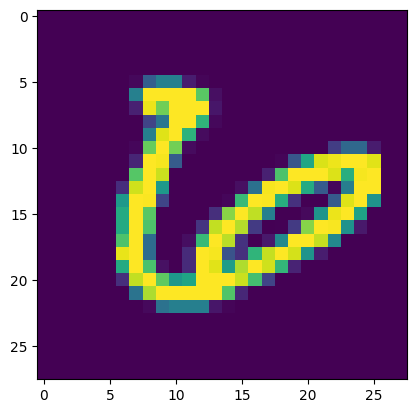

In [ ]:
t = 0
for input, _ in train_data:

    opt.zero_grad()

    label_pred = model(input)

    loss = criterion(label_pred.flatten(), input)
    
    loss.backward()
    
    opt.step()
    
    t+=1

    if t%5000==0 or t==1:
        print(f"Iteration: {t} | loss: {loss.item()}")
        res = label_pred.detach().numpy()
        plt.imshow(input.detach().numpy().reshape((28, 28)))
        plt.show()
        plt.imshow(res.squeeze(0))
        plt.show()

# Load Model

In [7]:
# torch.save(model2, "./models/autoencoder_v3.pth")

In [10]:
model = torch.load("./models/autoencoder_v1.pth")

In [32]:
res = model.decoder(torch.randn(8))

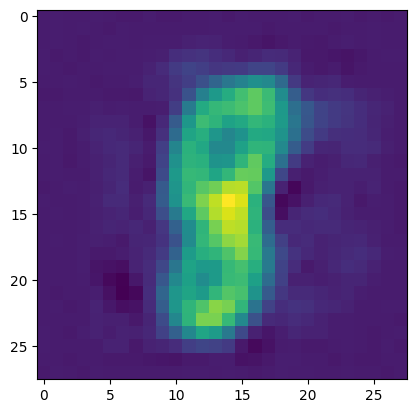

In [33]:
plt.imshow(res.detach().numpy().reshape(28, 28))